In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

2025-11-05 15:20:33.859864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762356033.956752     883 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762356033.984295     883 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762356034.191218     883 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762356034.191267     883 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762356034.191268     883 computation_placer.cc:177] computation placer alr

# 1. DATA PREPROCESSING AND LOADING

In [2]:
class BrainMRIDataLoader:
    """Load and preprocess brain MRI data from MSSEG dataset"""
    
    def __init__(self, data_dir, target_shape=(128, 128, 128)):
        self.data_dir = data_dir
        self.target_shape = target_shape
        
    def load_nifti(self, filepath):
        """Load NIfTI file and return numpy array"""
        try:
            img = nib.load(filepath)
            data = img.get_fdata()
            return data
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None
    
    def normalize_volume(self, volume):
        """Normalize volume with percentile clipping and z-score normalization"""
        volume = volume.astype(np.float32)
    
        # Remove outliers using percentile clipping
        p1, p99 = np.percentile(volume[volume > 0], [1, 99])
        volume = np.clip(volume, p1, p99)
    
        # Z-score normalization
        mean = np.mean(volume[volume > 0])
        std = np.std(volume[volume > 0])
        if std > 0:
            volume = (volume - mean) / std
    
        # Scale to [0, 1]
        min_val = np.min(volume)
        max_val = np.max(volume)
        if max_val - min_val > 0:
            volume = (volume - min_val) / (max_val - min_val)
    
        return volume
    
    def resize_volume(self, volume, target_shape):
        """Resize 3D volume to target shape"""
        factors = [t / s for t, s in zip(target_shape, volume.shape)]
        return zoom(volume, factors, order=1)
    
    def load_patient_data(self, patient_folder):
        """Load all modalities for a single patient"""
        patient_id = os.path.basename(patient_folder)
        base_name = patient_id.split('-')[1] if '-' in patient_id else '1'
        
        # Define file patterns
        modalities = {
            'flair': f'{base_name}-Flair.nii',
            't1': f'{base_name}-T1.nii',
            't2': f'{base_name}-T2.nii',
            'lesion_seg': f'{base_name}-LesionSeg-Flair.nii'
        }
        
        data = {}
        for key, filename in modalities.items():
            filepath = os.path.join(patient_folder, filename)
            if os.path.exists(filepath):
                volume = self.load_nifti(filepath)
                if volume is not None:
                    # Normalize and resize
                    volume = self.normalize_volume(volume)
                    volume = self.resize_volume(volume, self.target_shape)
                    data[key] = volume
        
        return data if len(data) > 0 else None
    
    def load_dataset(self):
        """Load entire dataset"""
        X_flair, X_t1, X_t2, y = [], [], [], []
        
        # Iterate through all patient folders
        for patient_folder in sorted(os.listdir(self.data_dir)):
            patient_path = os.path.join(self.data_dir, patient_folder)
            if os.path.isdir(patient_path):
                print(f"Loading {patient_folder}...")
                patient_data = self.load_patient_data(patient_path)
                
                if patient_data and 'flair' in patient_data and 'lesion_seg' in patient_data:
                    X_flair.append(patient_data['flair'])
                    X_t1.append(patient_data.get('t1', np.zeros(self.target_shape)))
                    X_t2.append(patient_data.get('t2', np.zeros(self.target_shape)))
                    
                    # Binarize segmentation mask
                    mask = patient_data['lesion_seg']
                    mask = (mask > 0).astype(np.float32)
                    y.append(mask)
        
        # Convert to numpy arrays
        # Convert to numpy arrays with explicit dtype
        X_flair = np.array(X_flair, dtype=np.float32)[..., np.newaxis]
        X_t1 = np.array(X_t1, dtype=np.float32)[..., np.newaxis]
        X_t2 = np.array(X_t2, dtype=np.float32)[..., np.newaxis]
        y = np.array(y, dtype=np.float32)[..., np.newaxis]
        
        # Concatenate modalities
        X = np.concatenate([X_flair, X_t1, X_t2], axis=-1)
        
        return X, y

# 2. DATA AUGMENTATION


In [3]:
def augment_volume(volume, mask):
    """Apply random augmentations to volume and mask"""
    # Random intensity scaling for contrast
    if np.random.random() > 0.5:
        scale = np.random.uniform(0.8, 1.2)
        volume = volume * scale
        volume = np.clip(volume, 0, 1)
    
    # Random gamma correction
    if np.random.random() > 0.5:
        gamma = np.random.uniform(0.8, 1.2)
        volume = np.power(volume, gamma)
    
    
    
    # Random rotation (90 degrees)
    k = np.random.randint(0, 4)
    volume = np.rot90(volume, k, axes=(0, 1))
    mask = np.rot90(mask, k, axes=(0, 1))
    
    # Add random noise
    noise = np.random.normal(0, 0.01, volume.shape)
    volume = volume + noise
    volume = np.clip(volume, 0, 1)
    
    return volume, mask

# 3. MODEL ARCHITECTURE - 3D U-NET WITH DOMAIN ADAPTATION


In [ ]:
def conv_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
    """Convolutional block with optional batch normalization"""
    x = layers.Conv3D(filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    """Encoder block with two convolutions and max pooling"""
    conv = conv_block(x, filters)
    conv = conv_block(conv, filters)
    pool = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv)
    return conv, pool

def decoder_block(x, skip, filters):
    """Decoder block with upsampling and skip connections"""
    x = layers.Conv3DTranspose(filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x

def attention_gate(x, g, filters):
    """Attention gate for focusing on relevant features"""
    theta_x = layers.Conv3D(filters, 1, strides=(2, 2, 2), padding='same')(x)
    phi_g = layers.Conv3D(filters, 1, padding='same')(g)
    
    add = layers.Add()([theta_x, phi_g])
    add = layers.Activation('relu')(add)
    
    psi = layers.Conv3D(1, 1, padding='same')(add)
    psi = layers.Activation('sigmoid')(psi)
    psi = layers.UpSampling3D(size=(2, 2, 2))(psi)
    
    return layers.Multiply()([x, psi])

def build_3d_unet(input_shape=(128, 128, 128, 3), num_classes=1, use_attention=True):
    """
    Build 3D U-Net model with optional attention gates
    
    Args:
        input_shape: Shape of input volume (depth, height, width, channels)
        num_classes: Number of output classes (1 for binary segmentation)
        use_attention: Whether to use attention gates
    """
    inputs = layers.Input(shape=input_shape)
    
    # Encoder path with more filters
    conv1, pool1 = encoder_block(inputs, 32)   
    conv2, pool2 = encoder_block(pool1, 64)   
    conv3, pool3 = encoder_block(pool2, 128)   
    conv4, pool4 = encoder_block(pool3, 256)  
    
    # Bottleneck
    bottleneck = conv_block(pool4, 512)       
    bottleneck = conv_block(bottleneck, 512)
    
    # Decoder path with attention
    if use_attention:
        conv4 = attention_gate(conv4, bottleneck, 256)
    dec4 = decoder_block(bottleneck, conv4, 256)

    if use_attention:
        conv3 = attention_gate(conv3, dec4, 128)
    dec3 = decoder_block(dec4, conv3, 128)
    
    if use_attention:
        conv2 = attention_gate(conv2, dec3, 64)
    dec2 = decoder_block(dec3, conv2, 64)
    
    if use_attention:
        conv1 = attention_gate(conv1, dec2, 32)
    dec1 = decoder_block(dec2, conv1, 32)

    # Output layer
    outputs = layers.Conv3D(num_classes, 1, activation='sigmoid', padding='same')(dec1)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='3D_UNet_Attention')
    return model


# 4. CUSTOM LOSSES AND METRICS

In [5]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for binary segmentation"""
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss for training"""
    return 1 - dice_coefficient(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal loss for handling class imbalance"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reshape(bce, [-1])
    
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    focal = alpha_t * tf.pow(1 - p_t, gamma) * bce
    
    return tf.reduce_mean(focal)

def combined_loss(y_true, y_pred):
    """Combined focal and dice loss with weighting"""
    focal = focal_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * focal + 0.5 * dice

def iou_metric(y_true, y_pred, threshold=0.5):
    """Intersection over Union metric"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)

# 5. TRAINING UTILITIES

In [6]:
class DataGenerator(keras.utils.Sequence):
    """Custom data generator for training with augmentation"""
    
    def __init__(self, X, y, batch_size=2, augment=True, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = np.empty((self.batch_size, *self.X.shape[1:]))
        y_batch = np.empty((self.batch_size, *self.y.shape[1:]))
        
        for i, idx in enumerate(indexes):
            x, y = self.X[idx], self.y[idx]
            if self.augment:
                x, y = augment_volume(x, y)
            X_batch[i] = x
            y_batch[i] = y
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 6. MAIN TRAINING PIPELINE

In [7]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

def train_model(data_dir, target_shape=(128, 128, 128), epochs=100, batch_size=2):
    
    """
    Complete training pipeline
    
    Args:
        data_dir: Path to MSSEG data directory
        target_shape: Target volume shape for resizing
        epochs: Number of training epochs
        batch_size: Batch size for training
    """
    
    print("=" * 80)
    print("CROSS-DISEASE BRAIN MRI SEGMENTATION MODEL")
    print("=" * 80)
    
    # 1. Load data
    print("\n[1/6] Loading and preprocessing data...")
    loader = BrainMRIDataLoader(data_dir, target_shape)
    X, y = loader.load_dataset()
    
    print(f"Dataset shape: X={X.shape}, y={y.shape}")
    print(f"Number of samples: {len(X)}")
    
    # 2. Split data
    print("\n[2/6] Splitting data into train/validation/test sets...")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # 3. Create data generators
    print("\n[3/6] Creating data generators...")
    train_gen = DataGenerator(X_train, y_train, batch_size=batch_size, augment=True)
    val_gen = DataGenerator(X_val, y_val, batch_size=batch_size, augment=False)
    
    # 4. Build model
    print("\n[4/6] Building 3D U-Net model with attention gates...")
    input_shape = X.shape[1:]
    model = build_3d_unet(input_shape=input_shape, use_attention=True)
    
    print(f"Model input shape: {input_shape}")
    print(f"Total parameters: {model.count_params():,}")

    optimizer = keras.optimizers.Adam(learning_rate=5e-5)
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)

    # 5. Compile model
    print("\n[5/6] Compiling model...")
    model.compile(
        optimizer=optimizer,
        loss=combined_loss,
        metrics=[dice_coefficient, iou_metric]
    )
    
    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_dice_coefficient',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_dice_coefficient',
            patience=15,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.CSVLogger('training_log.csv')
    ]
    
    # 6. Train model
    print("\n[6/6] Training model...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # 7. Evaluate on test set
    print("\n" + "=" * 80)
    print("EVALUATION ON TEST SET")
    print("=" * 80)
    test_results = model.evaluate(X_test, y_test, batch_size=1, verbose=1)
    print(f"\nTest Loss: {test_results[0]:.4f}")
    print(f"Test Dice Coefficient: {test_results[1]:.4f}")
    print(f"Test IoU: {test_results[2]:.4f}")
    
    # 8. Plot training history
    plot_training_history(history)
    
    # 9. Visualize predictions
    visualize_predictions(model, X_test, y_test, num_samples=3)
    
    return model, history

# 7. VISUALIZATION AND EVALUATION

In [8]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Dice coefficient
    axes[1].plot(history.history['dice_coefficient'], label='Train Dice')
    axes[1].plot(history.history['val_dice_coefficient'], label='Val Dice')
    axes[1].set_title('Dice Coefficient')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice')
    axes[1].legend()
    axes[1].grid(True)
    
    # IoU
    axes[2].plot(history.history['iou_metric'], label='Train IoU')
    axes[2].plot(history.history['val_iou_metric'], label='Val IoU')
    axes[2].set_title('IoU Metric')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_predictions(model, X_test, y_test, num_samples=3):
    """Visualize model predictions on test samples"""
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for idx in indices:
        x_sample = X_test[idx:idx+1]
        y_true = y_test[idx, :, :, :, 0]
        y_pred = model.predict(x_sample, verbose=0)[0, :, :, :, 0]
        
        # Get middle slice
        slice_idx = y_true.shape[2] // 2
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # FLAIR modality
        axes[0, 0].imshow(x_sample[0, :, :, slice_idx, 0], cmap='gray')
        axes[0, 0].set_title('FLAIR')
        axes[0, 0].axis('off')
        
        # T1 modality
        axes[0, 1].imshow(x_sample[0, :, :, slice_idx, 1], cmap='gray')
        axes[0, 1].set_title('T1')
        axes[0, 1].axis('off')
        
        # T2 modality
        axes[0, 2].imshow(x_sample[0, :, :, slice_idx, 2], cmap='gray')
        axes[0, 2].set_title('T2')
        axes[0, 2].axis('off')
        
        # Ground truth
        axes[1, 0].imshow(y_true[:, :, slice_idx], cmap='jet')
        axes[1, 0].set_title('Ground Truth')
        axes[1, 0].axis('off')
        
        # Prediction
        axes[1, 1].imshow(y_pred[:, :, slice_idx], cmap='jet')
        axes[1, 1].set_title('Prediction')
        axes[1, 1].axis('off')
        
        # Overlay
        axes[1, 2].imshow(x_sample[0, :, :, slice_idx, 0], cmap='gray')
        axes[1, 2].imshow(y_pred[:, :, slice_idx] > 0.5, cmap='jet', alpha=0.5)
        axes[1, 2].set_title('Overlay')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'prediction_sample_{idx}.png', dpi=300, bbox_inches='tight')
        plt.show()

# 8. INFERENCE ON CUSTOM DATA


In [9]:
def predict_on_custom_data(model, patient_folder, loader):
    """
    Make prediction on a new patient scan
    
    Args:
        model: Trained model
        patient_folder: Path to patient folder
        loader: BrainMRIDataLoader instance
    """
    print(f"\nPredicting on: {patient_folder}")
    
    # Load patient data
    patient_data = loader.load_patient_data(patient_folder)
    
    if patient_data is None or 'flair' not in patient_data:
        print("Error: Could not load patient data")
        return None
    
    # Prepare input
    X_input = np.stack([
        patient_data.get('flair', np.zeros(loader.target_shape)),
        patient_data.get('t1', np.zeros(loader.target_shape)),
        patient_data.get('t2', np.zeros(loader.target_shape))
    ], axis=-1)[np.newaxis, ...]
    
    # Predict
    prediction = model.predict(X_input, verbose=0)[0, :, :, :, 0]
    
    # Visualize
    slice_idx = prediction.shape[2] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(patient_data['flair'][:, :, slice_idx], cmap='gray')
    axes[0].set_title('FLAIR Input')
    axes[0].axis('off')
    
    axes[1].imshow(prediction[:, :, slice_idx], cmap='jet')
    axes[1].set_title('Predicted Lesions')
    axes[1].axis('off')
    
    axes[2].imshow(patient_data['flair'][:, :, slice_idx], cmap='gray')
    axes[2].imshow(prediction[:, :, slice_idx] > 0.5, cmap='jet', alpha=0.5)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'custom_prediction.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return prediction

# 9. USAGE EXAMPLE


CROSS-DISEASE BRAIN MRI SEGMENTATION MODEL

[1/6] Loading and preprocessing data...
Loading Patient-1...
Loading Patient-10...
Loading Patient-11...
Loading Patient-12...
Loading Patient-13...
Loading Patient-14...
Loading Patient-15...
Loading Patient-16...
Loading Patient-17...
Loading Patient-18...
Loading Patient-19...
Loading Patient-2...
Loading Patient-20...
Loading Patient-21...
Loading Patient-22...
Loading Patient-23...
Loading Patient-24...
Loading Patient-25...
Loading Patient-26...
Loading Patient-27...
Loading Patient-28...
Loading Patient-29...
Loading Patient-3...
Loading Patient-30...
Loading Patient-31...
Loading Patient-32...
Loading Patient-33...
Loading Patient-34...
Loading Patient-35...
Loading Patient-36...
Loading Patient-37...
Loading Patient-38...
Loading Patient-39...
Loading Patient-4...
Loading Patient-40...
Loading Patient-41...
Loading Patient-42...
Loading Patient-43...
Loading Patient-44...
Loading Patient-45...
Loading Patient-46...
Loading Patient-47

I0000 00:00:1762356116.850342     883 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model input shape: (32, 32, 32, 3)
Total parameters: 22,851,397

[5/6] Compiling model...

[6/6] Training model...
Epoch 1/100


/home/vaibh/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-11-05 15:22:03.763218: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14155776 exceeds 10% of free system memory.
2025-11-05 15:22:03.778812: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28311552 exceeds 10% of free system memory.
2025-11-05 15:22:03.809933: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14155776 exceeds 10% of free system memory.
I0000 00:00:1762356128.563354    1412 service.cc:152] XLA service 0x7f84b0003b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coefficient: 0.8378 - iou_metric: 0.9294 - loss: 0.0867
Epoch 1: val_dice_coefficient improved from -inf to 0.69992, saving model to best_model.keras


2025-11-05 15:22:34.215997: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14155776 exceeds 10% of free system memory.
2025-11-05 15:22:34.236215: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28311552 exceeds 10% of free system memory.


42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - dice_coefficient: 0.8382 - iou_metric: 0.9298 - loss: 0.0865 - val_dice_coefficient: 0.6999 - val_iou_metric: 0.9623 - val_loss: 0.1674 - learning_rate: 5.0000e-05
Epoch 2/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coefficient: 0.8668 - iou_metric: 0.9666 - loss: 0.0697
Epoch 2: val_dice_coefficient improved from 0.69992 to 0.74534, saving model to best_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - dice_coefficient: 0.8670 - iou_metric: 0.9665 - loss: 0.0696 - val_dice_coefficient: 0.7453 - val_iou_metric: 0.9623 - val_loss: 0.1394 - learning_rate: 5.0000e-05
Epoch 3/100
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - dice_coefficient: 0.8867 - iou_metric: 0.9660 - loss: 0.0590
Epoch 3: val_dice_coefficient improved from 0.74534 to 0.80400, saving model to best_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - dice_coefficient: 0.8869 - iou_metric: 0.9660 - loss: 0.0589 - val_dice_coefficient: 0.8040 - val_iou_metric: 0.9623 - v

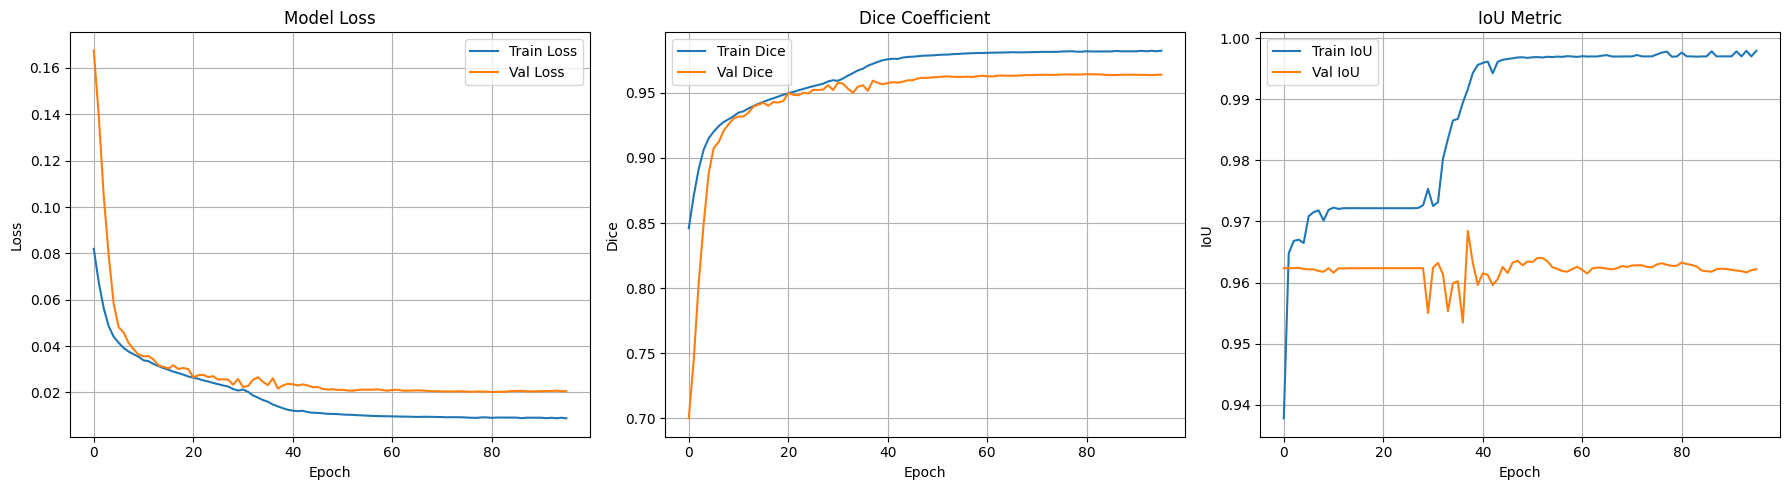

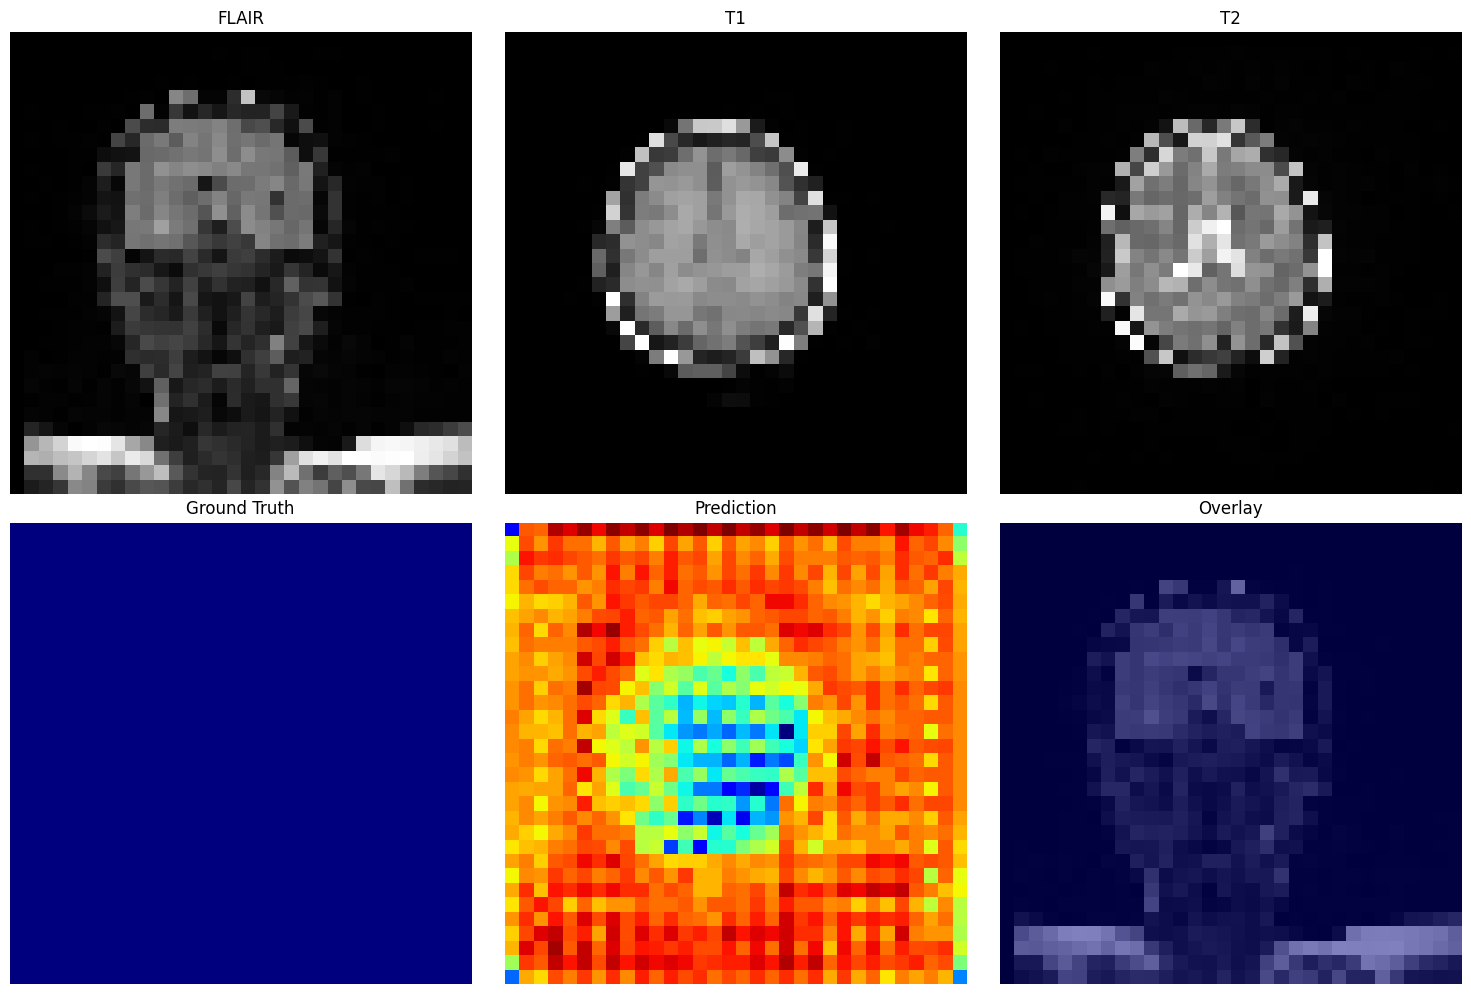

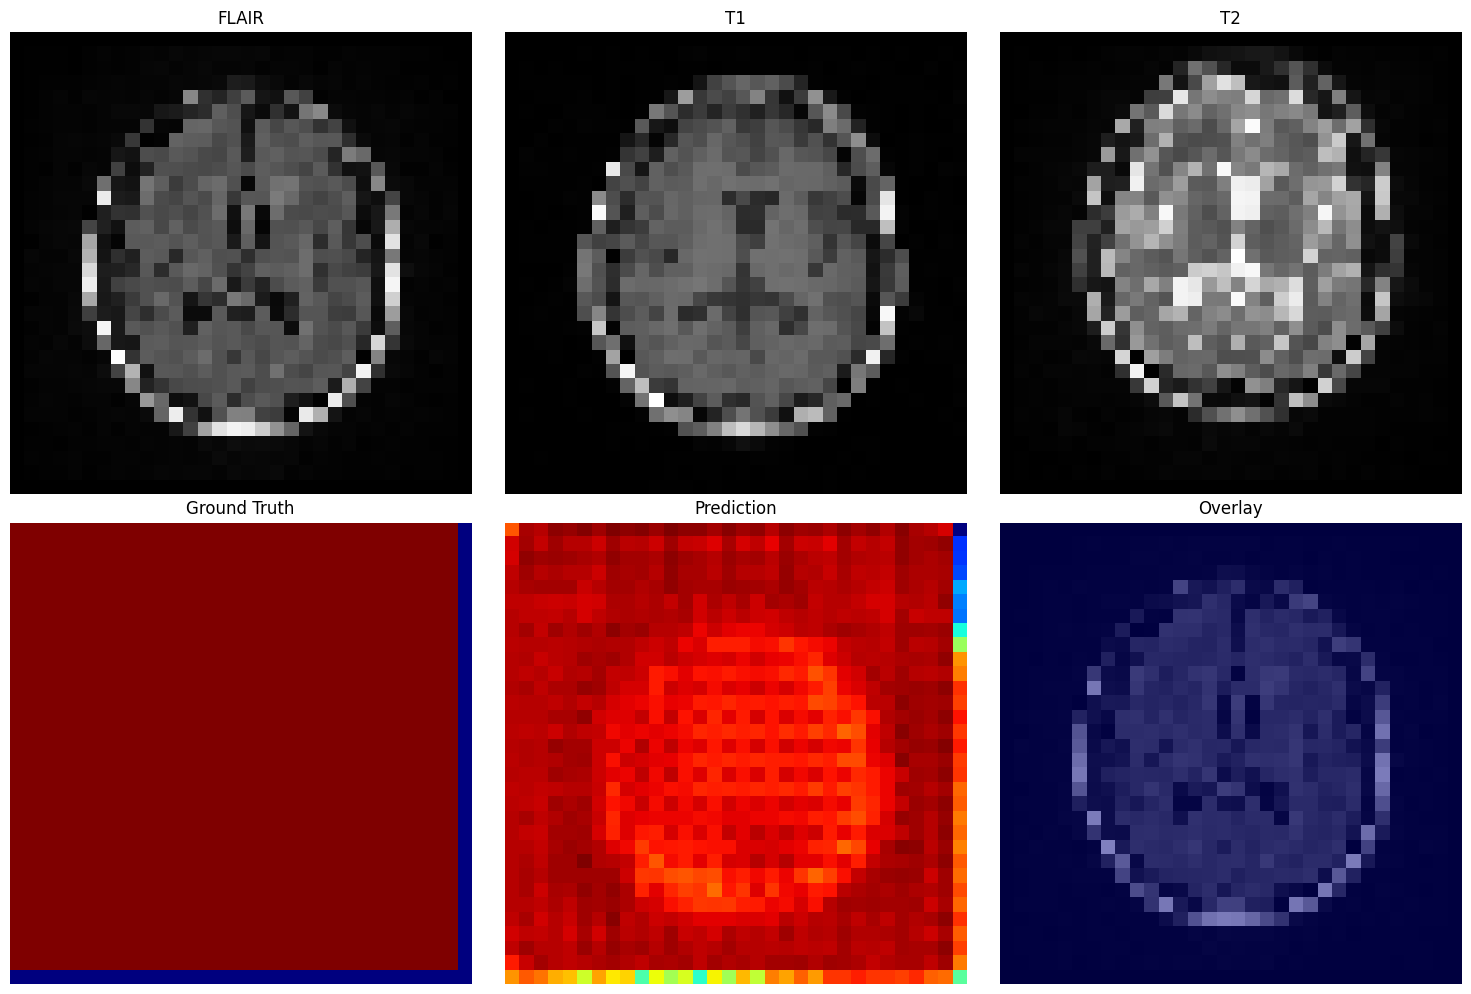

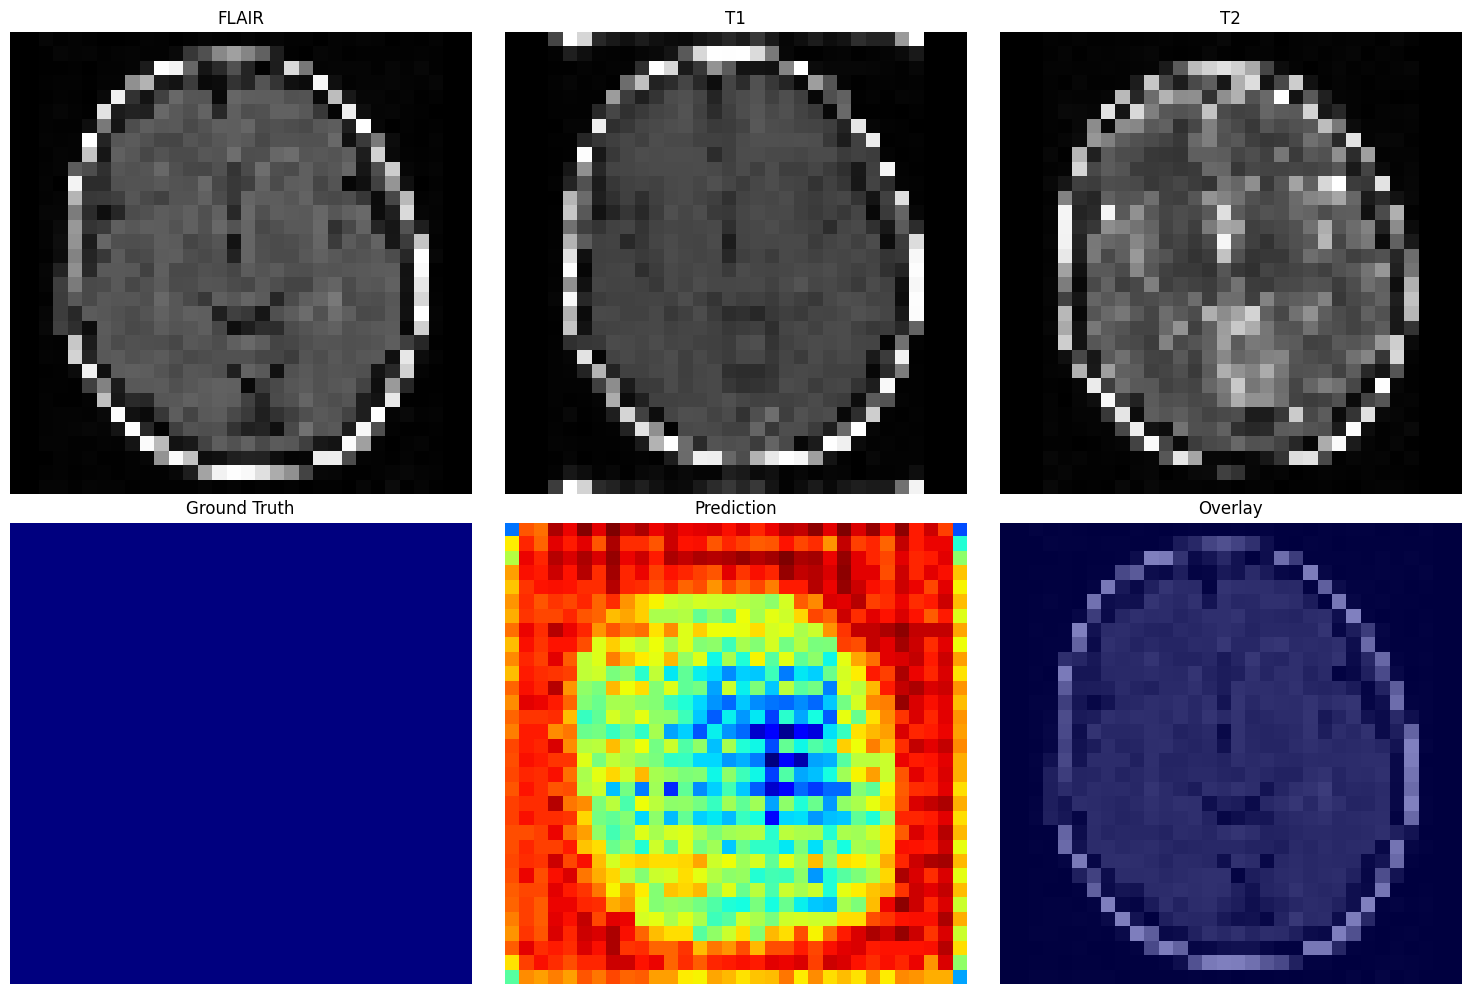


Model saved as 'final_brain_mri_model.h5'

Predicting on: /home/vaibh/ANN_Project/MSSEG_data/Patient-1


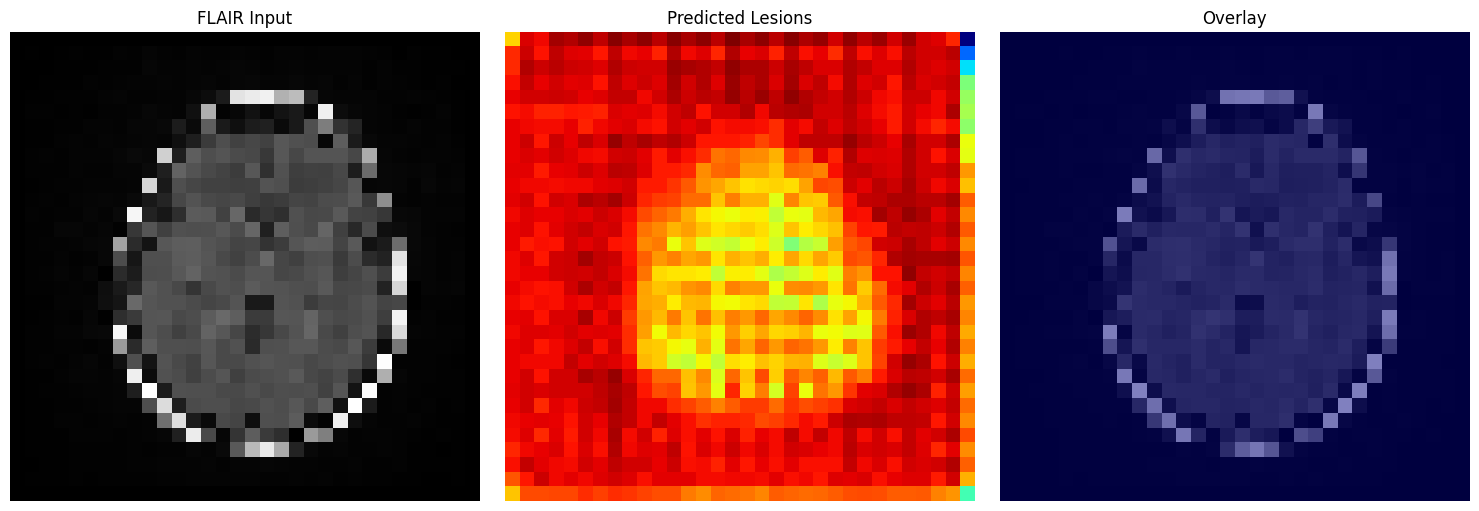


Prediction complete!

TRAINING COMPLETE!


In [10]:
if __name__ == "__main__":
    # Set paths
    DATA_DIR = "/home/vaibh/ANN_Project/MSSEG_data"
    
    # Configuration
    TARGET_SHAPE = (32, 32,32)  
    EPOCHS = 100
    BATCH_SIZE = 1
    
    # Train model
    model, history = train_model(
        data_dir=DATA_DIR,
        target_shape=TARGET_SHAPE,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    # Save final model
    model.save('final_brain_mri_model.h5')
    print("\nModel saved as 'final_brain_mri_model.h5'")
    
    # Predict on custom patient data
    loader = BrainMRIDataLoader(DATA_DIR, TARGET_SHAPE)
    custom_patient = os.path.join(DATA_DIR, "Patient-1")
    
    if os.path.exists(custom_patient):
        prediction = predict_on_custom_data(model, custom_patient, loader)
        print("\nPrediction complete!")
    
    print("\n" + "=" * 80)
    print("TRAINING COMPLETE!")
    print("=" * 80)